In [1]:
import os
import glob
import json
import numpy as np
import mplhep as hep
import awkward as ak
import matplotlib.pyplot as plt

hep.style.use(hep.styles.CMS)

In [8]:
FRACS = ["2e3", "1e4", "1e5", "1e6"]
MODEL_TYPES = {
    'fine_tuning': "Fine-tuning",
    'from_scratch': "From scratch",
    'fixed_backbone': "Fine-tuning \n(fixed backbone)",
    # 'ParticleTransformer': "ParticleTransformer"
    
}
TRAINING_TYPES = ['jet_regression', 'dm_multiclass', "binary_classification"]
# TRAINING_TYPES = ['dm_multiclass']
# BASE_DIR = "/home/laurits/20241114_results/202041014_binary_classification"
# BASE_DIR2 = "/home/laurits/ml-tau-en-reg/training-outputs/20250109_OmniParT_2GPT_layers/"
# BASE_DIR = "/home/laurits/ml-tau-en-reg/training-outputs/20250113_OmniParT_fixed_embedding_table/"
BASE_DIR = "/home/laurits/tmp/20241204_ParT_ntrain_v2/"
# NEW_FINETUNING = "/home/laurits/ml-tau-en-reg/training-outputs/20241220_unfreeze_from_start/"
# ParT_DIR = "/home/laurits/ml-tau-en-reg/training-outputs/20201204_ParT_ntrain_v2/"
PERFORMANCE_KEYS = {
    "jet_regression": ["loss_validation", "IQR_validation", "median_validation"],
    "binary_classification": ["loss_validation", "precision_validation", "recall_validation", "F1_validation"],
    "dm_multiclass": ["loss_validation", "precision_validation", "recall_validation", "F1_validation"]
}
OUTPUT_DIR = "/home/laurits/tmp/20250120_OmniParT_general_performance"
os.makedirs(OUTPUT_DIR, exist_ok=True)
Y_LABELS = {
    "IQR_validation": r"$p_T \, \, resol. (q_{75} - q_{25})/q_{50}$",
    "median_validation": r"$p_T scale (q_{50})$",
    "precision_validation": "precision",
    "recall_validation": "recall",
    "F1_validation": "F1",
    "loss_validation": "validation loss"
}

COLORS = {
    "fine_tuning": "green",
    "from_scratch": "red",
    "fixed_backbone": "blue",
    "ParticleTransformer": "black"
}

In [9]:
def get_metrics_values(training_type):
    keys = PERFORMANCE_KEYS[training_type]
    model_metrics = {}
    for m_type in list(MODEL_TYPES.keys()):
        model_metrics[m_type] = {key: {"mean": [], "std": []} for key in keys}
        model_metrics[m_type]["fracs"] = []
        for fraction in FRACS:
            # if m_type == "ParticleTransformer":
            #     wcp_path = os.path.join(ParT_DIR, "*", f"trainfrac_{fraction}", training_type, "ParticleTransformer", "history.json")
            # elif m_type == "fine_tuning":
            #     wcp_path = os.path.join(NEW_FINETUNING, "*", f"trainfrac_{fraction}", training_type, f"OmniParT_{m_type}", "history.json")
            # else:
            wcp_path = os.path.join(BASE_DIR, "*", f"trainfrac_{fraction}", training_type, f"OmniParT_{m_type}", "history.json")
            metric_values = {key: [] for key in keys}
            # print(wcp_path)
            for metrics_path in glob.glob(wcp_path):
                if not os.path.exists(metrics_path):
                    print(f"ERROR: {metrics_path} is not started")
                    continue
                with open(metrics_path, "rt") as in_file:
                    metrics_info = json.load(in_file)
                # print(metrics_path, len(metrics_info["loss_validation"]))
                # if len(metrics_info["loss_validation"]) < 100:
                    # print(f"ERROR: {metrics_path} is not finished")
                    # continue
                    # print(metrics_path, len(metrics_info["loss_validation"]))
                min_loss_idx = np.argmin(metrics_info["loss_validation"])  # Actually could also take the min value of the parameter?
                for key in keys:
                    metric_values[key].append(np.nan_to_num(metrics_info[key][min_loss_idx])) # added nan_to_num
            for key in keys:
                model_metrics[m_type][key]["mean"].append(np.mean(metric_values[key]))
                model_metrics[m_type][key]["std"].append(np.std(metric_values[key]))
            # model_metrics[m_type]["fracs"].append(fraction)
    return model_metrics

def plot_all_performances(training_type):
    metrics_values = get_metrics_values(training_type)
    output_dir = os.path.join(OUTPUT_DIR, training_type)
    os.makedirs(output_dir, exist_ok=True)
    for key in PERFORMANCE_KEYS[training_type]:
        output_path = os.path.join(output_dir, f"{key}.pdf")
        plot_performance(metrics_values, key, output_path)

def plot_performance(metrics_values, key, output_path):
    fs = [float(f) for f in FRACS]
    for m_type, name in MODEL_TYPES.items():
        mean = np.array(metrics_values[m_type][key]["mean"])
        std = np.array(metrics_values[m_type][key]["std"])
        plt.plot(fs, mean, label=name, color=COLORS[m_type])
        plt.fill_between(fs, mean - std, mean + std, color=COLORS[m_type], alpha=0.3)
    plt.legend()
    # plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Number of training jets")
    plt.ylabel(Y_LABELS[key])
    plt.savefig(output_path, bbox_inches="tight", format="pdf")
    plt.close("all")
        
        

In [10]:
for training_type in TRAINING_TYPES:
    plot_all_performances(training_type)

In [224]:
def plot_task_losses(training_type, logy=True):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(16,9))
    axes = [ax1, ax2, ax3, ax4]
    for i, (ax, frac) in enumerate(zip(axes, FRACS)):
        for m_type, name in MODEL_TYPES.items():
            if m_type == "ParticleTransformer":
                wcp_path = os.path.join(ParT_DIR, "*", f"trainfrac_{frac}", training_type, "ParticleTransformer", "history.json")
            else:
                wcp_path = os.path.join(BASE_DIR, "*", f"trainfrac_{frac}", training_type, f"OmniParT_{m_type}", "history.json")
            val_losses = []
            for path in glob.glob(wcp_path):
                with open(path, "rt") as in_file:
                    val_losses.append(json.load(in_file)["loss_validation"])
            val_losses = ak.Array(val_losses)
            # print(np.arange(100))
            # print(ak.mean(val_losses, axis=0))
            ax.plot(np.arange(100), ak.mean(val_losses, axis=0), label=name, color=COLORS[m_type])
            ax.fill_between(
                np.arange(100),
                ak.mean(val_losses, axis=0) - ak.std(val_losses, axis=0),
                ak.mean(val_losses, axis=0) + ak.std(val_losses, axis=0),
                color=COLORS[m_type], alpha=0.3
            )
            ax.legend()
            if logy:
                ax.set_yscale("log")
            ax.set_title(f"{frac} training jets")
            if (i == 0) or (i == 2):
                ax.set_ylabel("Validation Loss")
            if (i == 2) or (i == 3):
                ax.set_xlabel("Epoch")
    fig.savefig(os.path.join(OUTPUT_DIR, f"{training_type}.pdf"))

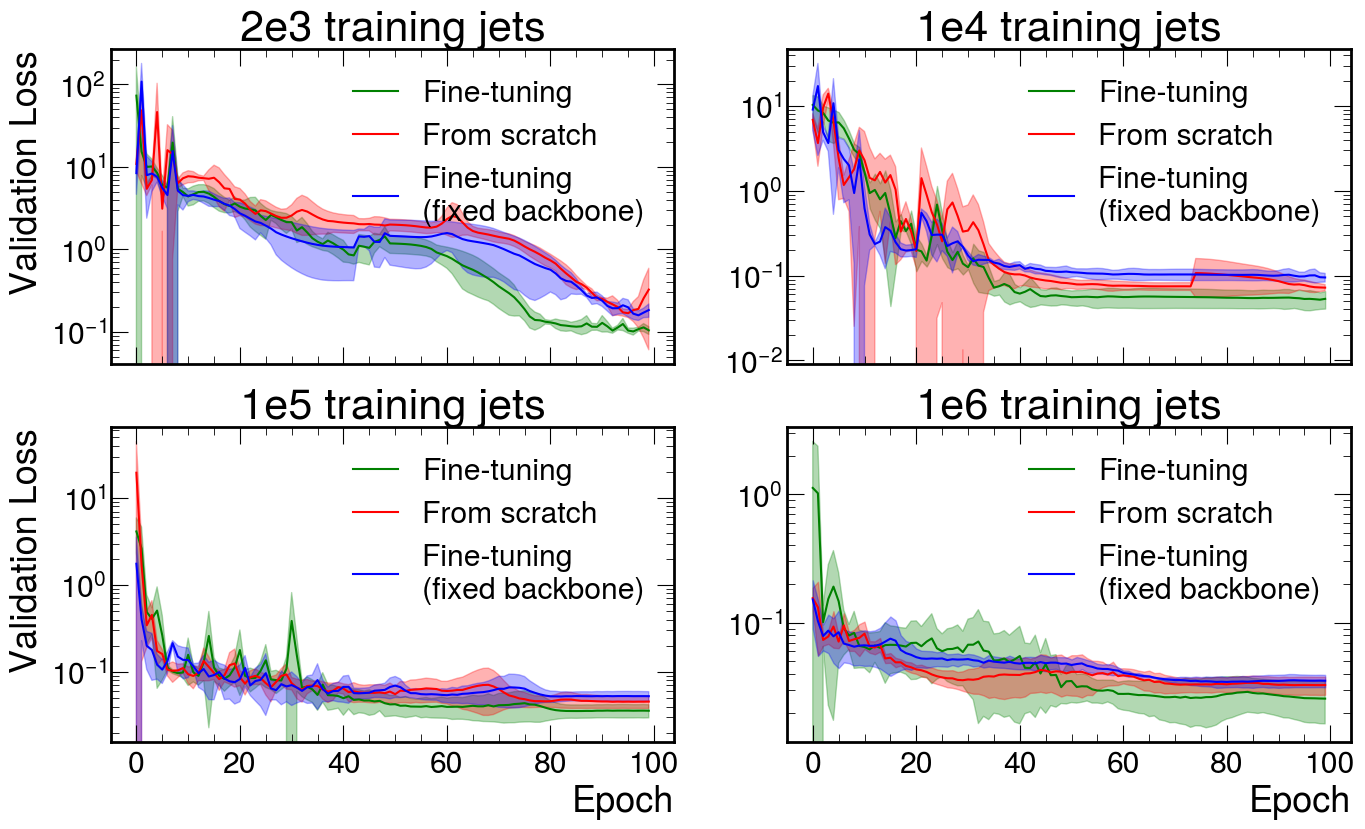

In [225]:
plot_task_losses("binary_classification")

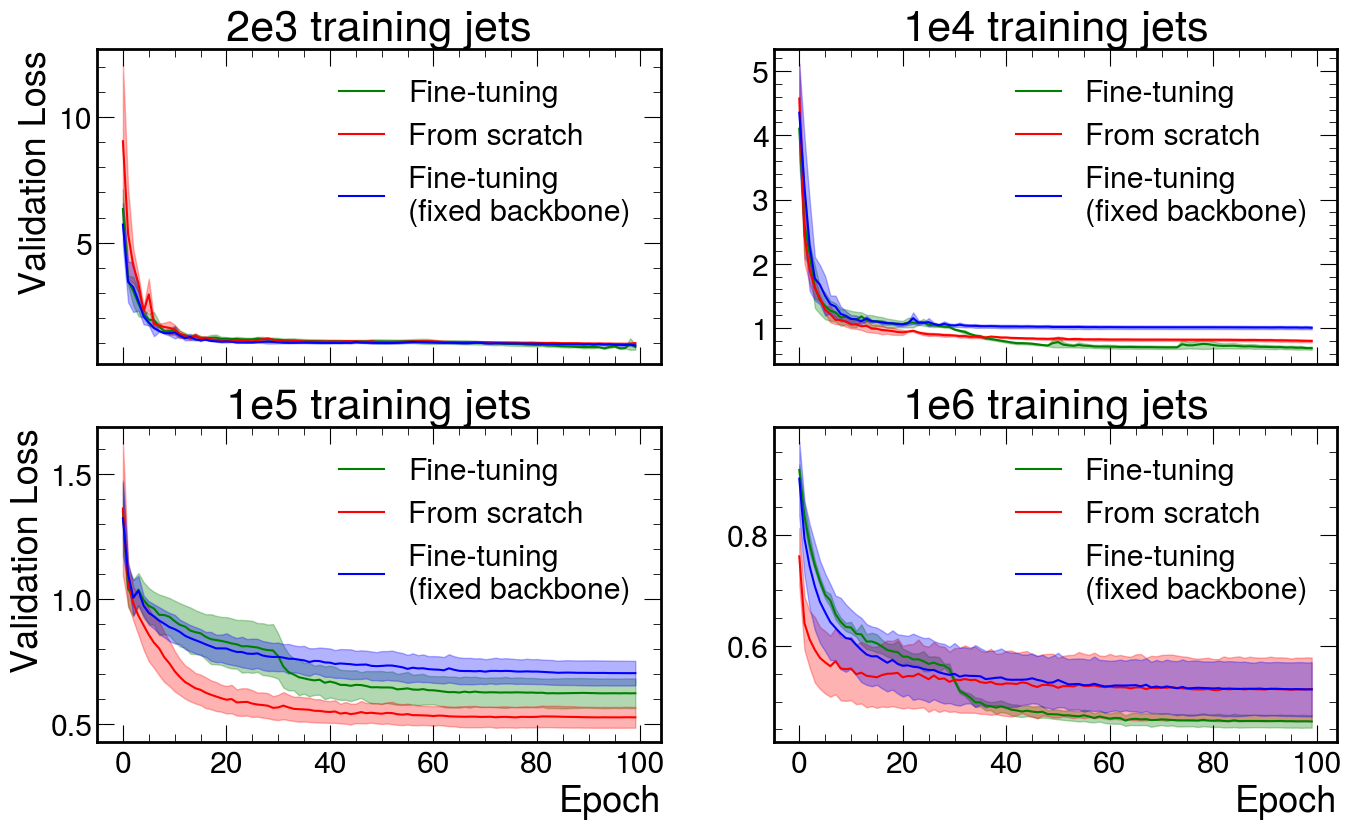

In [226]:
plot_task_losses("dm_multiclass", logy=False)

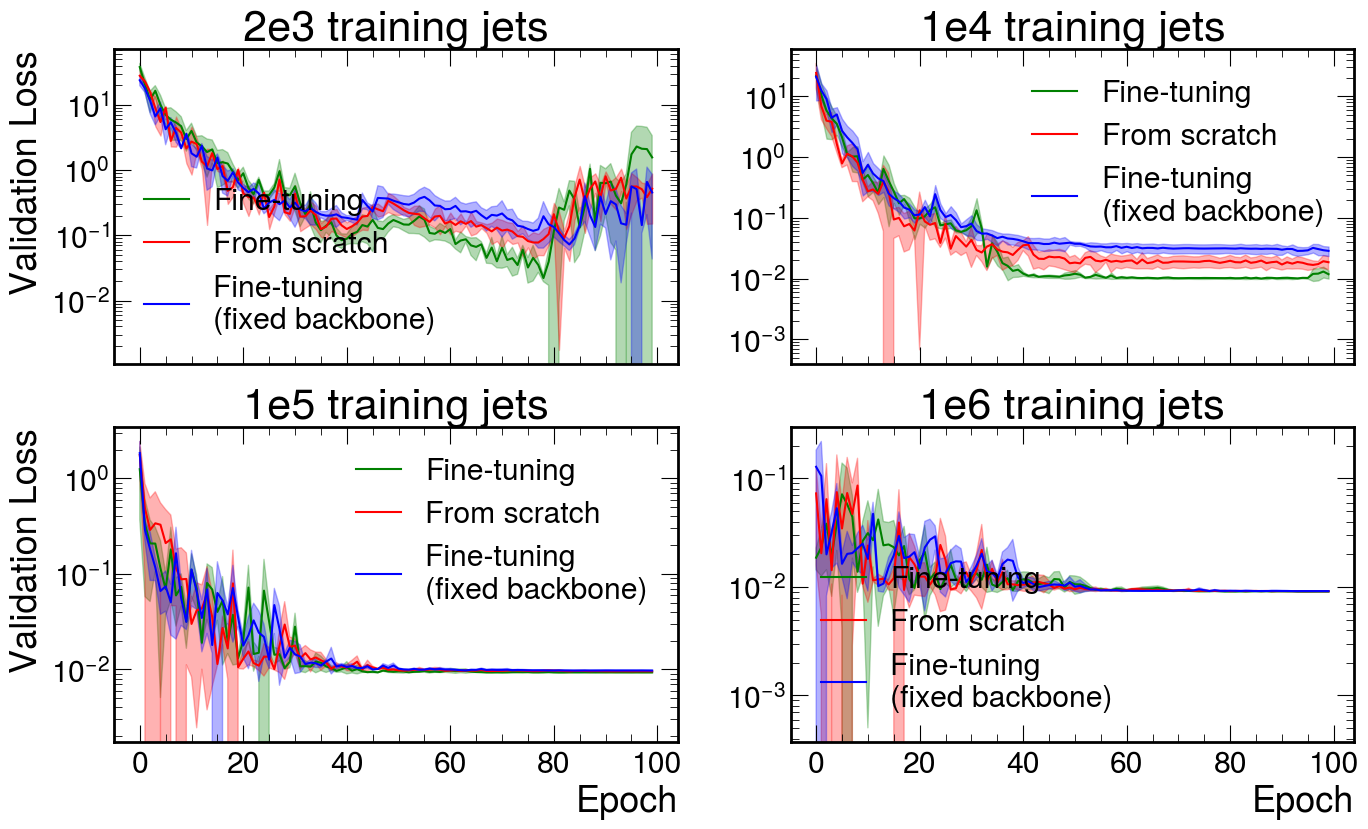

In [227]:
plot_task_losses("jet_regression")

In [90]:
ParT_DIR2 = "/home/laurits/ml-tau-en-reg/training-outputs/20201211_ParT_no_PMHA/"

In [102]:
colors = {
    "v1": "green",
    "v2": "red"
}
def compare_parT(training_type, logy=True):
    model_types = ["v1", "v2"]
    output_dir = "/home/laurits/20241217_NoMHA"
    os.makedirs(output_dir, exist_ok=True)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(16,9))
    axes = [ax1, ax2, ax3, ax4]
    for i, (ax, frac) in enumerate(zip(axes, FRACS)):
        for m_type in model_types:
            if m_type == "v2":
                wcp_path = os.path.join(ParT_DIR2, "*", f"trainfrac_{frac}", training_type, "ParticleTransformer", "history.json")
            else:
                wcp_path = os.path.join(ParT_DIR, "*", f"trainfrac_{frac}", training_type, "ParticleTransformer", "history.json")
            val_losses = []
            for path in glob.glob(wcp_path):
                with open(path, "rt") as in_file:
                    val_losses.append(json.load(in_file)["loss_validation"])
            val_losses = ak.Array(val_losses)
            # print(np.arange(100))
            # print(ak.mean(val_losses, axis=0))
            name = 'with P-MHA' if m_type == "v1" else 'no P-MHA'
            ax.plot(np.arange(len(ak.mean(val_losses, axis=0))), ak.mean(val_losses, axis=0), label=name, color=colors[m_type])
            ax.fill_between(
                np.arange(len(ak.mean(val_losses, axis=0))),
                ak.mean(val_losses, axis=0) - ak.std(val_losses, axis=0),
                ak.mean(val_losses, axis=0) + ak.std(val_losses, axis=0),
                color=colors[m_type], alpha=0.3
            )
            ax.legend()
            if logy:
                ax.set_yscale("log")
            ax.set_title(f"{frac} training jets")
            if (i == 0) or (i == 2):
                ax.set_ylabel("Validation Loss")
            if (i == 2) or (i == 3):
                ax.set_xlabel("Epoch")
    fig.savefig(os.path.join(output_dir, f"{training_type}.png"))

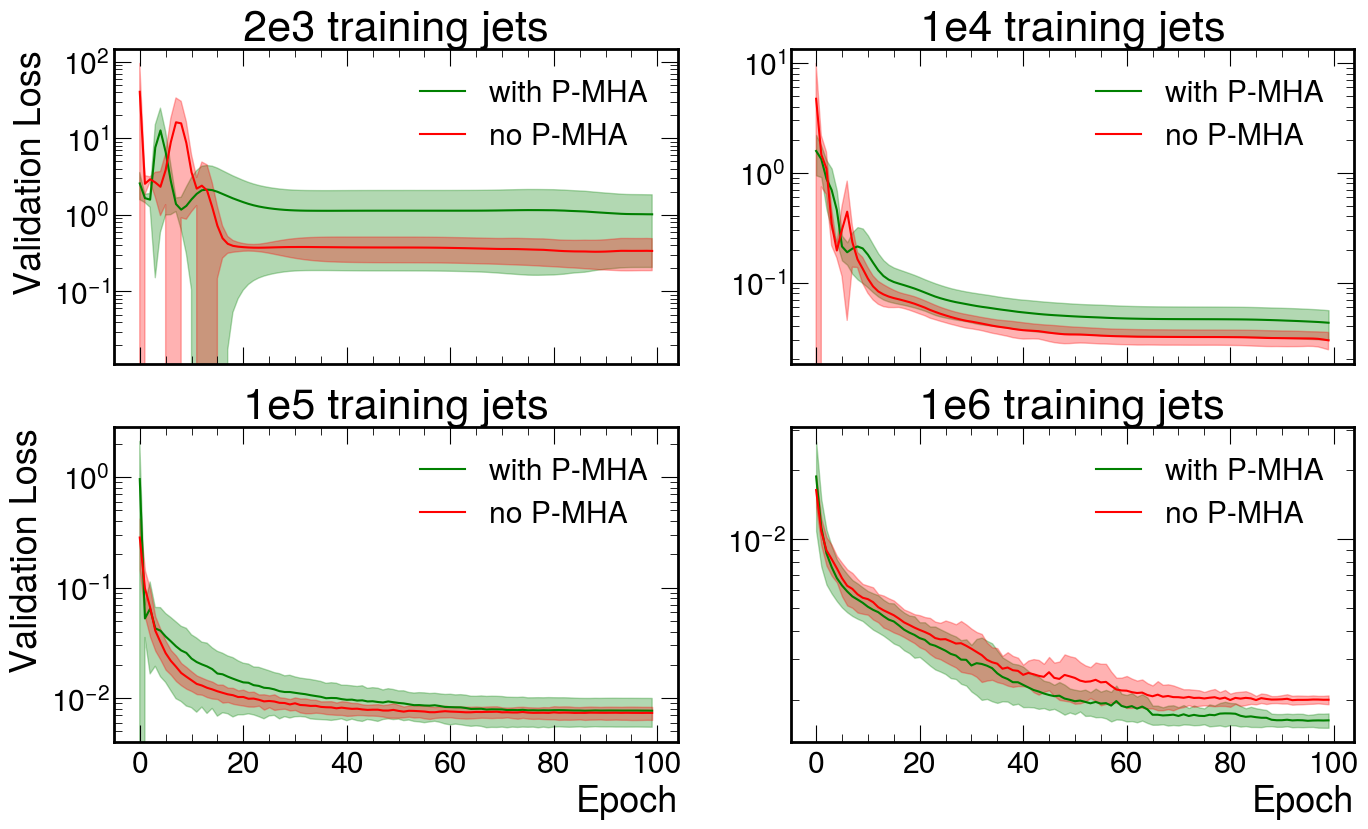

In [103]:
compare_parT("binary_classification")

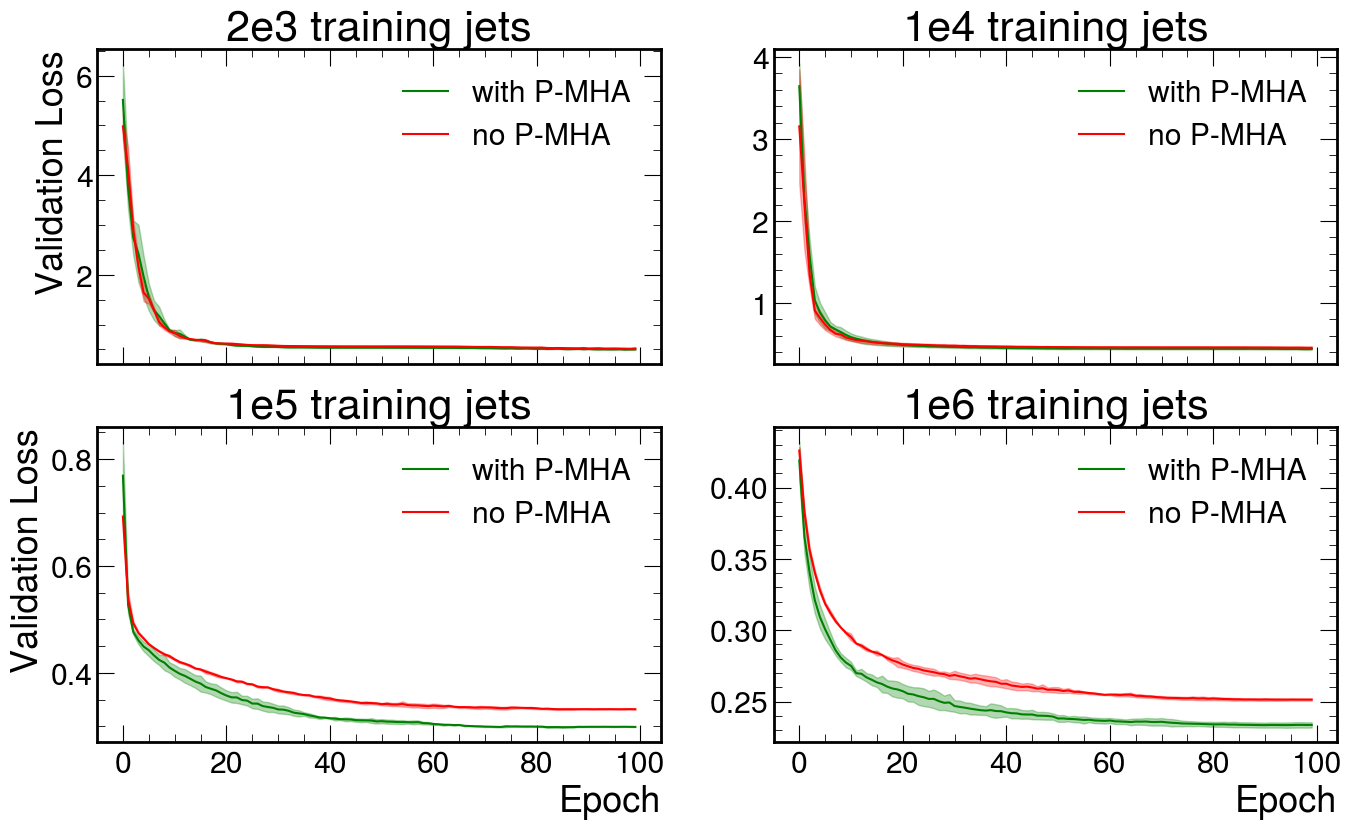

In [104]:
compare_parT("dm_multiclass", logy=False)

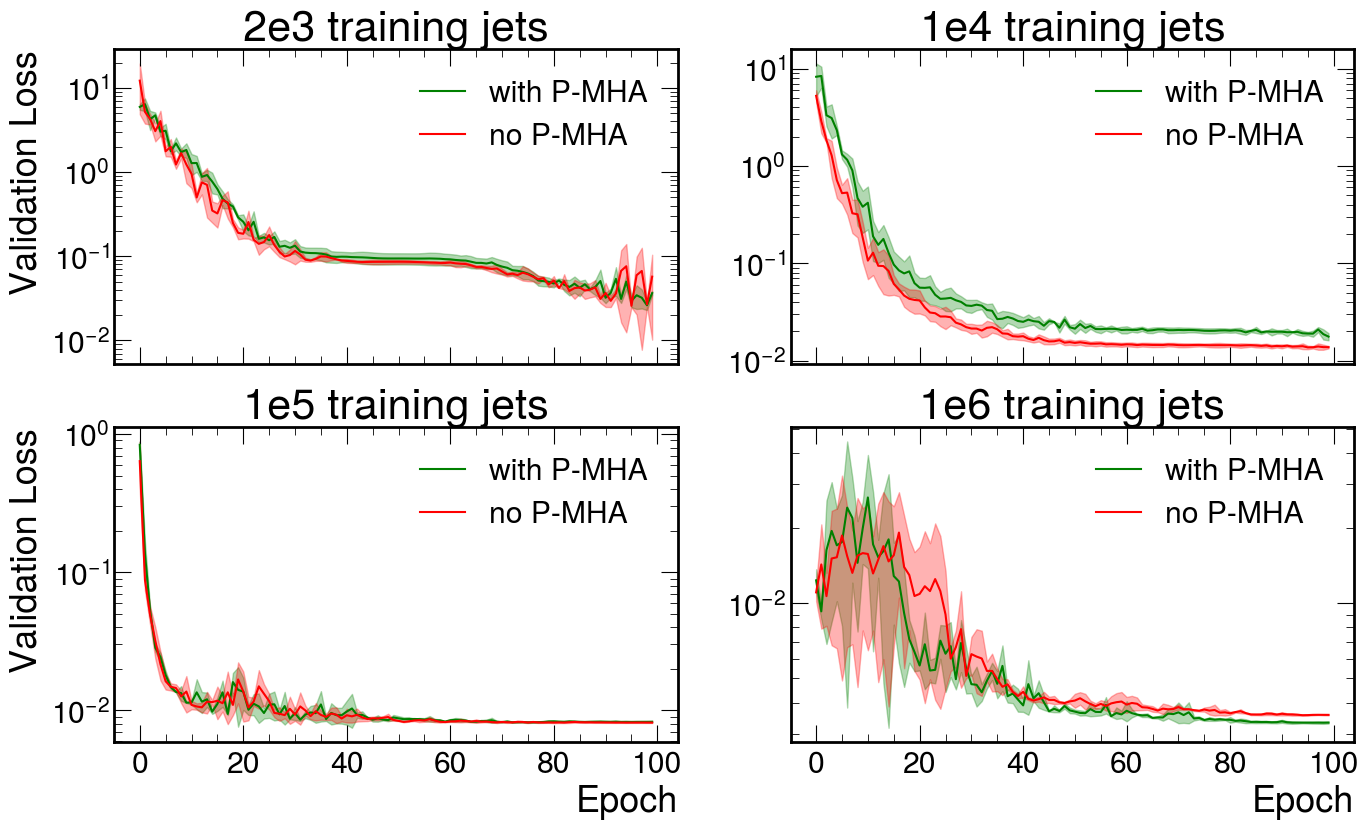

In [105]:
compare_parT("jet_regression")

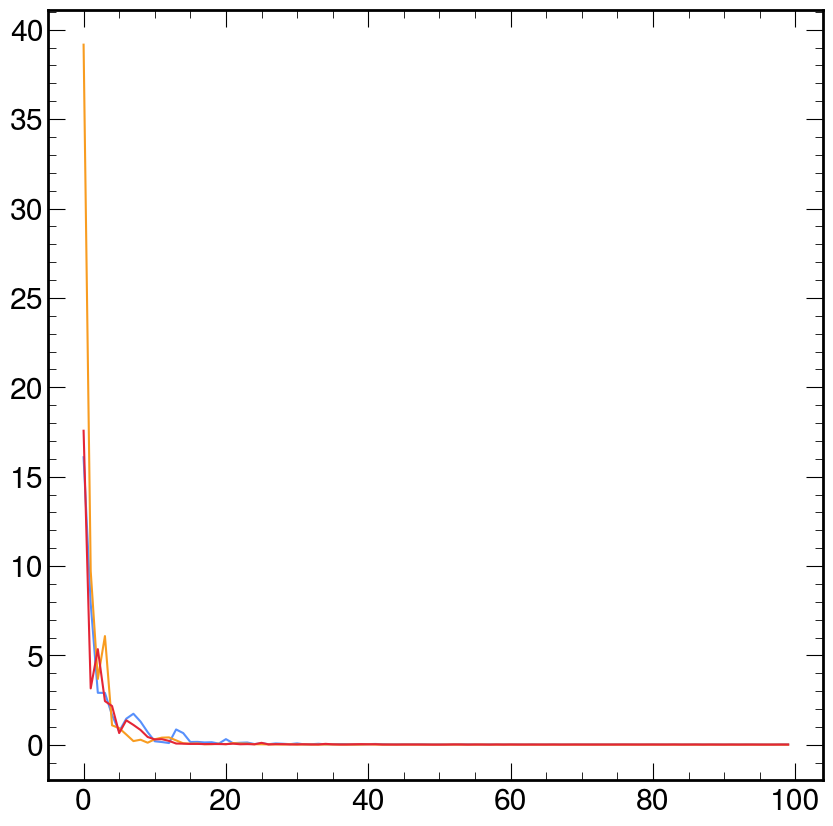

In [128]:
wcp_path = os.path.join(BASE_DIR, "*", f"trainfrac_1e4", "jet_regression", "OmniParT_from_scratch", "history.json")
# wcp_path = '/home/laurits/2024121*_OmniParT_losses_debug_LR1e-*/binary_classification/OmniParT_from_scratch/history.json'
val_losses = []
for path in glob.glob(wcp_path):
    with open(path, "rt") as in_file:
        losses = json.load(in_file)["loss_validation"]
        val_losses.append(losses)
        plt.plot(np.arange(len(losses)), losses) 
val_losses = ak.Array(val_losses)

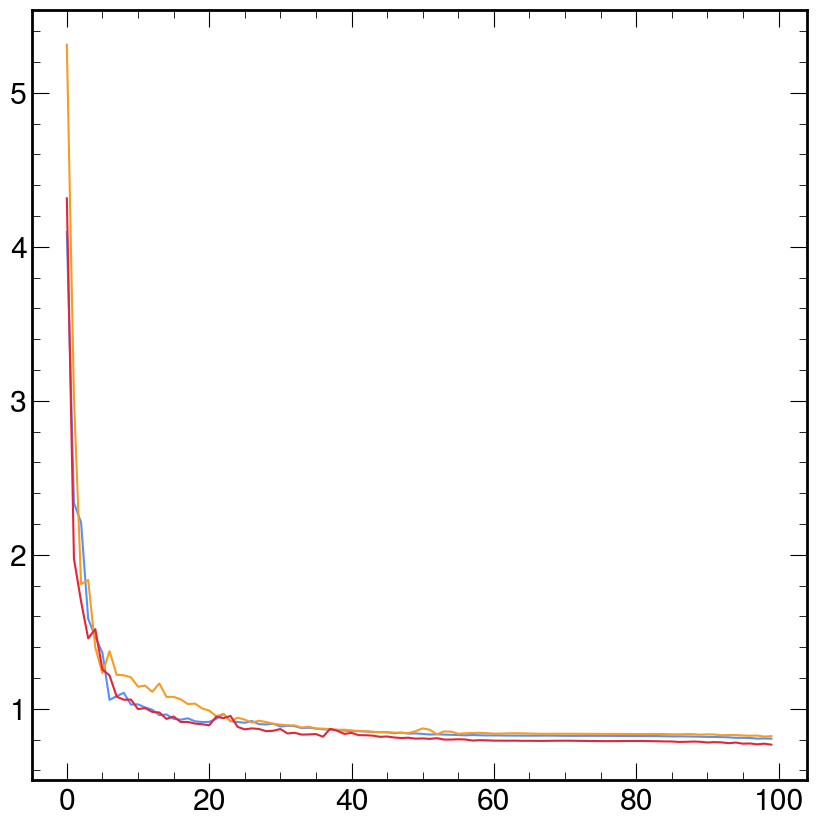

In [127]:
wcp_path = os.path.join(BASE_DIR, "*", f"trainfrac_1e4", "dm_multiclass", "OmniParT_from_scratch", "history.json")
# wcp_path = '/home/laurits/2024121*_OmniParT_losses_debug_LR1e-*/binary_classification/OmniParT_from_scratch/history.json'
val_losses = []
for path in glob.glob(wcp_path):
    with open(path, "rt") as in_file:
        losses = json.load(in_file)["loss_validation"]
        val_losses.append(losses)
        plt.plot(np.arange(len(losses)), losses) 
val_losses = ak.Array(val_losses)

Text(0, 1, 'Validation loss')

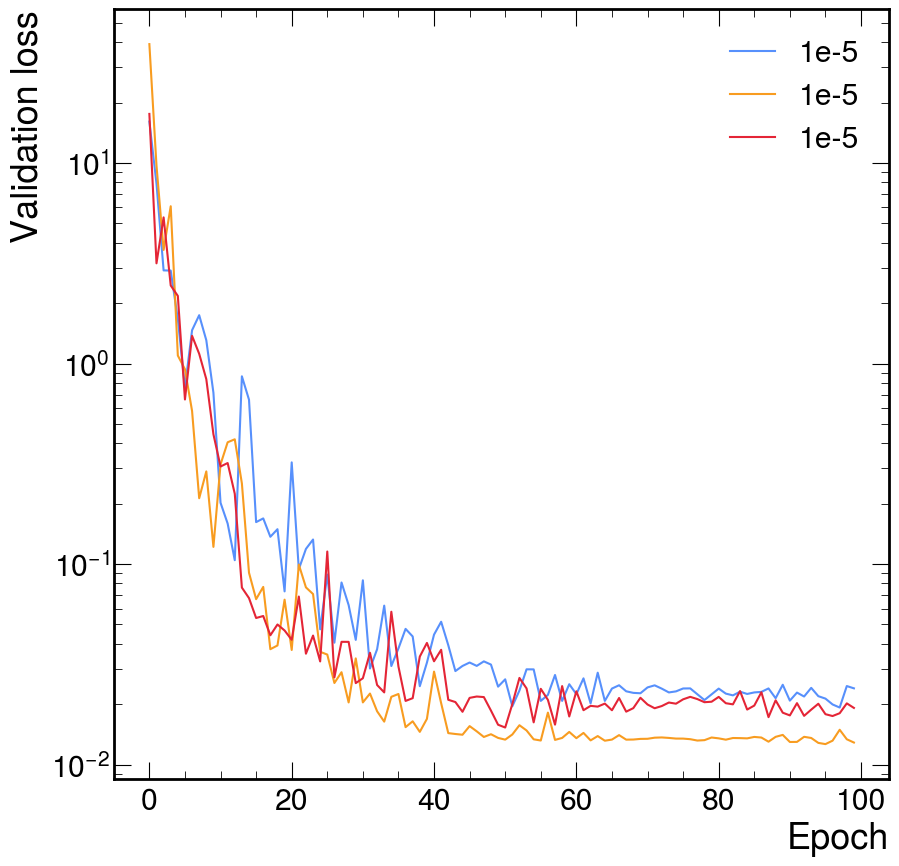

In [170]:
wcp_path = os.path.join(BASE_DIR, "*", f"trainfrac_1e4", "jet_regression", "OmniParT_from_scratch", "history.json")
val_losses = []
for path in glob.glob(wcp_path):
    with open(path, "rt") as in_file:
        losses = json.load(in_file)["loss_validation"]
        val_losses.append(losses)
        if "1e-3" in path:
            label = "1e-3"
        elif "1e-4" in path:
            label="1e-4"
        else:
            label="1e-5"
        plt.plot(np.arange(len(losses)), losses, label=label) 
val_losses = ak.Array(val_losses)
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')

Text(0, 1, 'Validation loss')

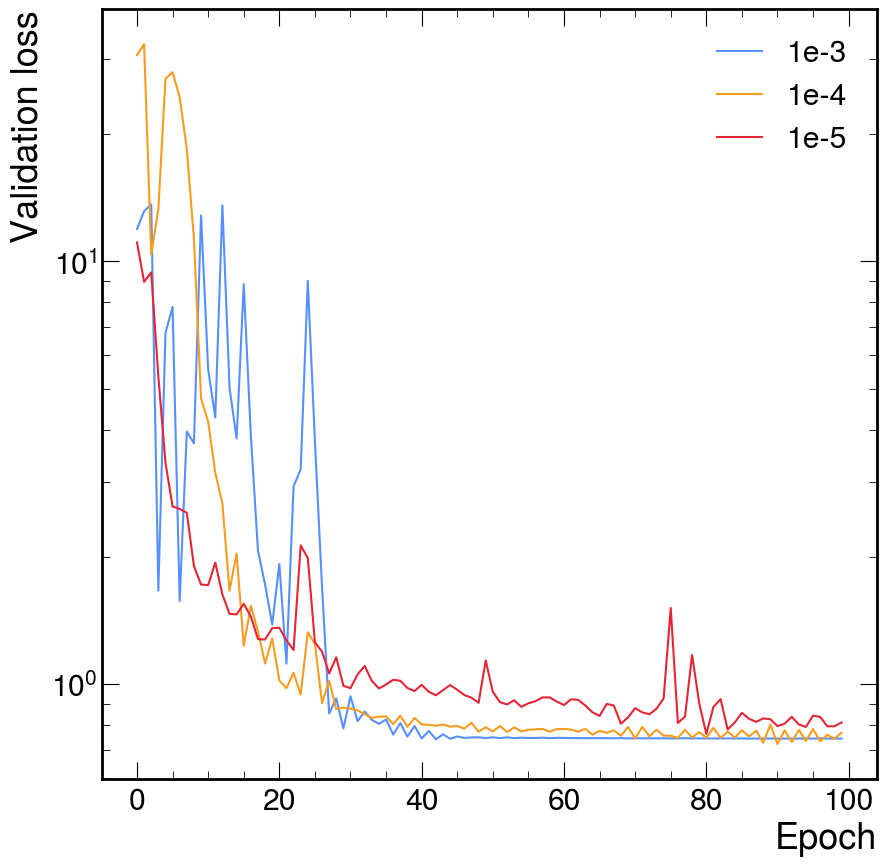

In [166]:
# wcp_path = os.path.join(BASE_DIR, "*", f"trainfrac_1e4", "binary_classification", "OmniParT_from_scratch", "history.json")
wcp_path = '/home/laurits/2024121*_OmniParT_losses_debug_LR1*/binary_classification/OmniParT_from_scratch/history.json'
val_losses = []
for path in glob.glob(wcp_path):
    with open(path, "rt") as in_file:
        losses = json.load(in_file)["loss_validation"]
        val_losses.append(losses)
        if "1e-3" in path:
            label = "1e-3"
        elif "1e-4" in path:
            label="1e-4"
        else:
            label="1e-5"
        plt.plot(np.arange(len(losses)), losses, label=label) 
val_losses = ak.Array(val_losses)
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')

In [182]:
# Compare the performance of fine-tuning for the cases: 1) unfreezing backbone from start; 2)unfreezing from iteration 30.

def plot_task_losses2(training_type, logy=True):
    output_dir = '/home/laurits/tmp/2GPT_Layer_training/'
    os.makedirs(output_dir, exist_ok=True)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(16,9))
    axes = [ax1, ax2, ax3, ax4]
    for i, (ax, frac) in enumerate(zip(axes, FRACS)):
        new_wcp_path = os.path.join(BASE_DIR2, "*", f"trainfrac_{frac}", training_type, f"OmniParT_fine_tuning", "history.json")
        old_wcp_path = os.path.join(BASE_DIR, "*", f"trainfrac_{frac}", training_type, f"OmniParT_fine_tuning", "history.json")
        # old
        old_val_losses = []
        for path in glob.glob(old_wcp_path):
            with open(path, "rt") as in_file:
                old_val_losses.append(json.load(in_file)["loss_validation"])
        old_val_losses = ak.Array(old_val_losses)

        ax.plot(np.arange(100), ak.mean(old_val_losses, axis=0), label="Original", color='blue')
        ax.fill_between(
            np.arange(100),
            ak.mean(old_val_losses, axis=0) - ak.std(old_val_losses, axis=0),
            ak.mean(old_val_losses, axis=0) + ak.std(old_val_losses, axis=0),
            color='blue', alpha=0.3
        )

        # new
        new_val_losses = []
        for path in glob.glob(new_wcp_path):
            with open(path, "rt") as in_file:
                new_val_losses.append(json.load(in_file)["loss_validation"])
        new_val_losses = ak.Array(new_val_losses)

        ax.plot(np.arange(len(ak.mean(new_val_losses, axis=0))), ak.mean(new_val_losses, axis=0), label="2 GPT Layers", color='red')
        ax.fill_between(
            np.arange(len(ak.mean(new_val_losses, axis=0))),
            ak.mean(new_val_losses, axis=0) - ak.std(new_val_losses, axis=0),
            ak.mean(new_val_losses, axis=0) + ak.std(new_val_losses, axis=0),
            color='red', alpha=0.3
        )
        ax.legend()
        if logy:
            ax.set_yscale("log")
        ax.set_title(f"{frac} training jets")
        if (i == 0) or (i == 2):
            ax.set_ylabel("Validation Loss")
        if (i == 2) or (i == 3):
            ax.set_xlabel("Epoch")
    fig.savefig(os.path.join(output_dir, f"{training_type}.pdf"))

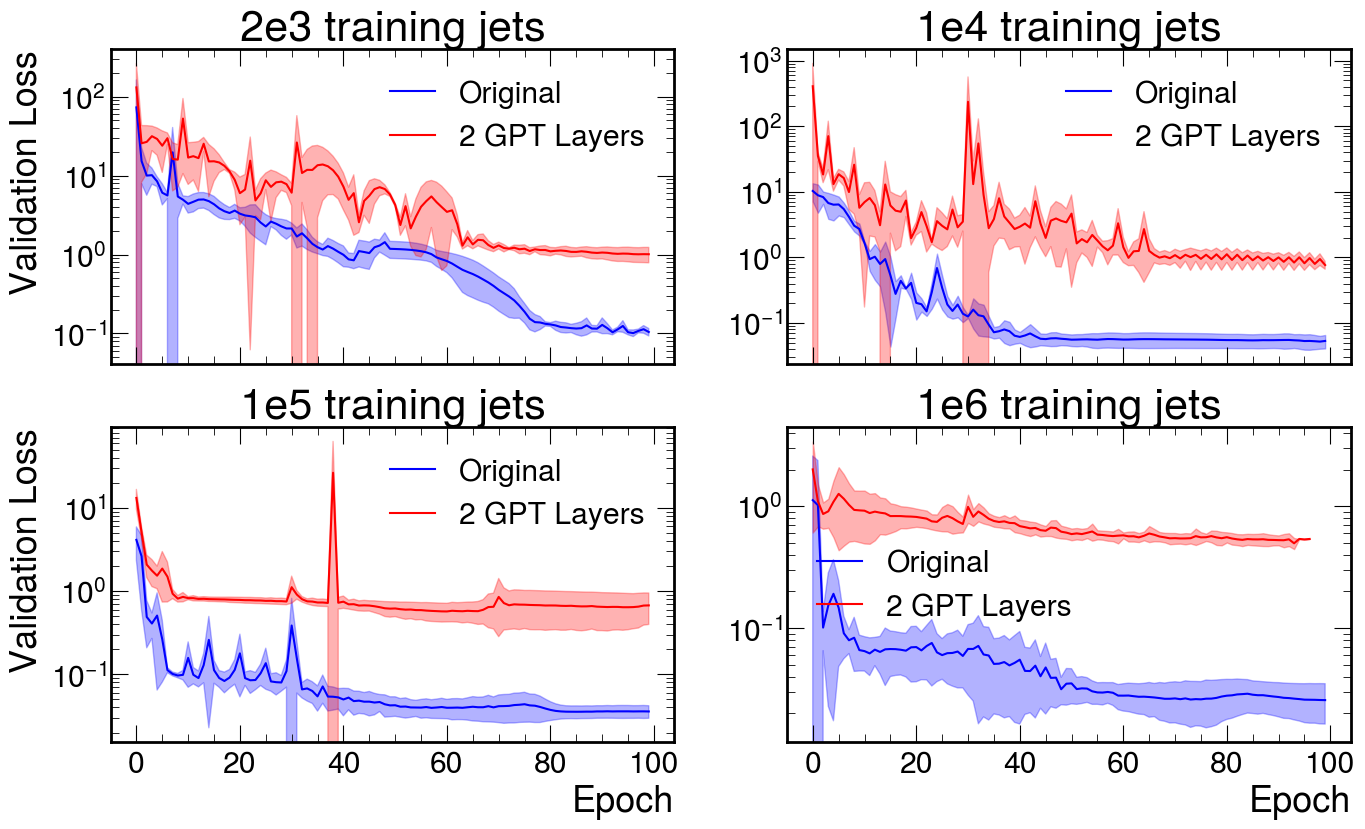

In [183]:
plot_task_losses2("binary_classification")

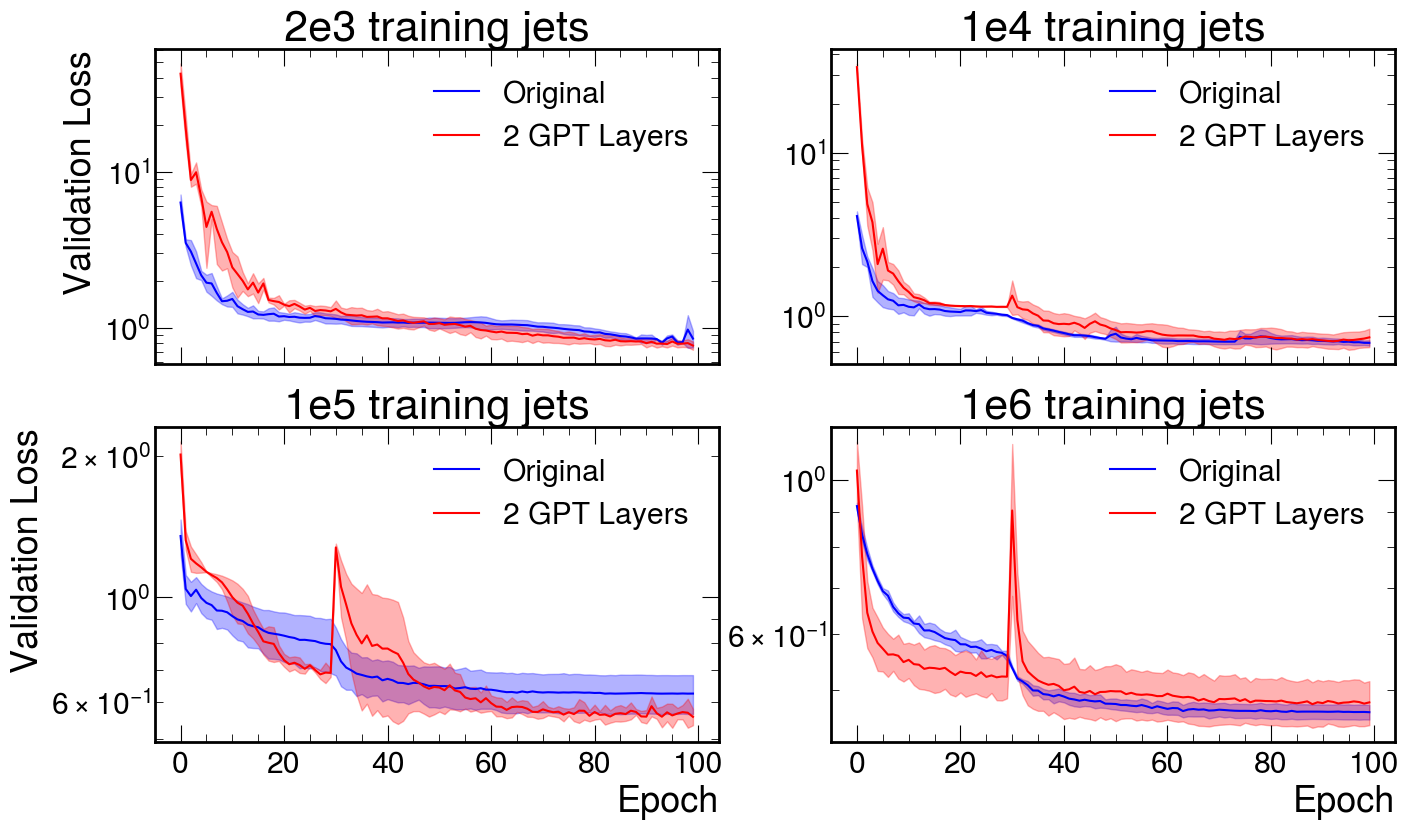

In [184]:
plot_task_losses2("dm_multiclass")

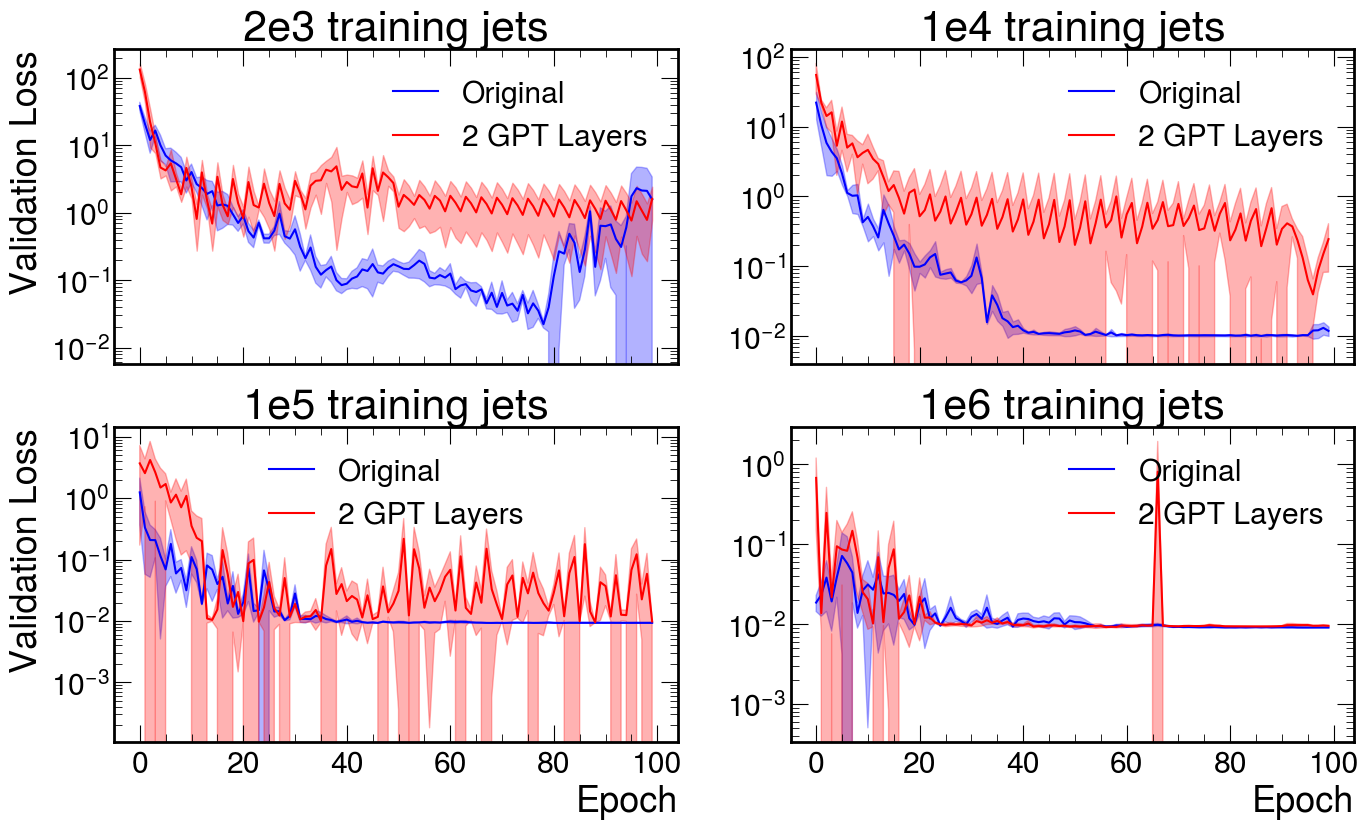

In [185]:
plot_task_losses2("jet_regression")